# Depth Visualizer for Multiple EXR Files

Select multiple `.exr` files and visualize their R, G, B channels and combined RGB in sequence.

In [1]:
%matplotlib inline
import os
import tkinter as tk
from tkinter import filedialog

import OpenEXR
import Imath
import numpy as np
import matplotlib.pyplot as plt

# File-selection dialog for multiple files
root = tk.Tk()
root.withdraw()
filepaths = filedialog.askopenfilenames(
    title="Select one or more OpenEXR files",
    filetypes=[("OpenEXR files", "*.exr"), ("All files", "*.*")]
)
root.destroy()

filepaths = list(filepaths)
print(f"Selected {len(filepaths)} files:")
for f in filepaths:
    print(" -", f)

Selected 1 files:
 - C:/Users/Tharu/VRFrameworkDatasetScene/Assets/Output/left_depth_exr/frame_0014.exr



Processing: C:/Users/Tharu/VRFrameworkDatasetScene/Assets/Output/left_depth_exr/frame_0014.exr
 R channel shape: (480, 640)
 G channel shape: (480, 640)
 B channel shape: (480, 640)


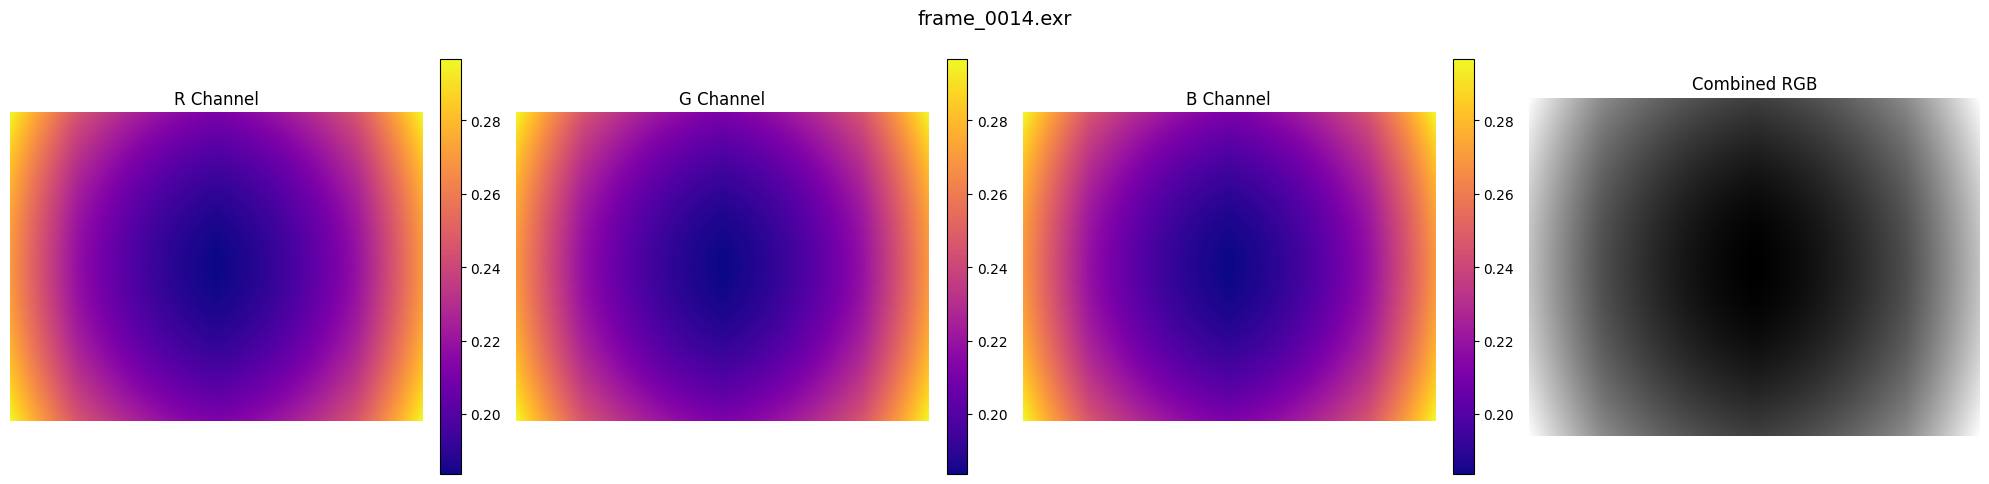

In [ ]:
# Process and visualize each file
# Function definitions
def load_exr(filename):
    """Load R, G, B channels from an EXR into numpy arrays."""
    exr = OpenEXR.InputFile(filename)
    dw = exr.header()["dataWindow"]
    W = dw.max.x - dw.min.x + 1
    H = dw.max.y - dw.min.y + 1
    pt = Imath.PixelType(Imath.PixelType.FLOAT)

    channels = {}
    for c in ("R", "G", "B"):
        buf = exr.channel(c, pt)
        arr = np.frombuffer(buf, dtype=np.float32)
        channels[c] = arr.reshape(H, W)

    return channels

def normalize_channel(arr):
    """Scale a float32 array to [0,1] for display."""
    mn, mx = arr.min(), arr.max()
    return (arr - mn) / (mx - mn + 1e-8)

for filepath in filepaths:
    if not os.path.isfile(filepath):
        print(f"File not found: {filepath}")
        continue

    print(f"\nProcessing: {filepath}")
    channels = load_exr(filepath)
    for c in channels:
        print(f" {c} channel shape: {channels[c].shape}")

    # Normalize and stack for RGB
    normed = {c: normalize_channel(channels[c]) for c in ("R", "G", "B")}
    rgb = np.stack([normed[c] for c in ("R", "G", "B")], axis=-1)

    # Plot
    fig, axs = plt.subplots(1, 4, figsize=(20, 5))
    for i, c in enumerate(("R", "G", "B")):
        im = axs[i].imshow(channels[c], cmap="plasma")
        axs[i].set_title(f"{c} Channel")
        axs[i].axis("off")
        plt.colorbar(im, ax=axs[i], fraction=0.046, pad=0.04)

    axs[3].imshow(rgb)
    axs[3].set_title("Combined RGB")
    axs[3].axis("off")

    plt.suptitle(os.path.basename(filepath), fontsize=14)
    plt.tight_layout()
    plt.show()